In [298]:
# -*- coding: utf-8 -*-
# 测试环境: python3.9.6

# *****************************************调库*************************************************#
import pandas as pd

from sqlalchemy import create_engine
from datetime import datetime
from matplotlib import pyplot as plt
# 设置显示中文字体
# 显示汉字
plt.rc("font",family='FangSong')


# *****************************************连接取数*********************************************#
engine  = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format('root', '123456', 'localhost', '3306', 'erp_jd_dwd'))  
engine1 = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format('root', '123456', 'localhost', '3306', 'bi'))
conn = create_engine("mssql+pymssql://{}:{}@{}:{}/{}".format('sa', '123456', '10.242.21.1', '1433', 'bi'))

df_sales = pd.read_sql_query('select * from erp_jd_dwd_dim_saleorders;', engine)

df_sales = df_sales[(df_sales['bumen'] == '渠道')&(df_sales['danjulxmc'] != '年返销售订单')]

# 去除内部订单
list_ = ['杭州游卡文化创意有限公司','上海飞之火电竞信息科技有限公司','杭州泳淳网络技术有限公司','杭州迷思文化创意有限公司','杭州迷思文化创意有限公司-西西弗']
df_sales = df_sales[~df_sales['kehumc'].isin(list_)]
data = df_sales[['kehumc','riqi','xiaoshousl','jiashuihj']]

1）R（Recency）：最近一次消费时间间隔，指用户最近一次消费时间距离现在的时间间隔；

2）F（Frequency）：消费频率，指用户一段时间内消费了多少次；

3）M（Monetary）：消费金额，指用户一段时间内的消费金额。

In [299]:
data.reset_index(drop=True,inplace=True)
data.reset_index(inplace=True)

In [300]:
column_name = 'xiaoshousl'
column_name1 = '总销量'

In [301]:
# 查看数据描述性统计的信息
print(data.describe())

# 按【订单号】和【用户 ID】分组后，获取【发货日期】列的最大值和【总金额】列的总和
grouped_data = data.groupby(['index','kehumc'], as_index=False).agg({'riqi': 'max', column_name: 'sum'})
# 计算时间间隔  
today = datetime.now()
grouped_data['时间间隔'] = (pd.to_datetime(today) - pd.to_datetime(grouped_data['riqi'])).dt.days

              index    xiaoshousl      jiashuihj
count  93017.000000  93017.000000   93017.000000
mean   46508.000000    116.743251    1228.649235
std    26851.839332    531.965866    4533.881182
min        0.000000      1.000000       0.000000
25%    23254.000000     20.000000     200.000000
50%    46508.000000     40.000000     342.000000
75%    69762.000000     80.000000     720.000000
max    93016.000000  86400.000000  289800.000000


In [302]:
# 按【用户 ID】分组后，获取【时间间隔】列的最小值、【订单号】列的数量，以及【总金额】列的总和
rfm_data = grouped_data.groupby('kehumc', as_index=False).agg({'时间间隔': 'min', 'index': 'count', column_name: 'sum'})
# 修改列名
rfm_data.columns = ['客户', '时间间隔', '总次数', column_name1]
rfm_data

,客户,时间间隔,总次数,总销量
0,一二三三国际贸易（福建）有限公司,1,233,59236.0
1,七彩动漫玩具商行,15,90,4911.0
2,三亚富嘉文具用品有限公司,78,143,4517.0
3,三河市首鼎体育用品销售有限公司,49,120,7776.0
4,上书房（廊坊）文化传播有限公司,124,35,151.0
...,...,...,...,...
811,鹤城区小宝贝玩具批发部,581,18,830.0
812,黄文平,67,121,6141.0
813,黄若惜,193,22,880.0
814,黑龙江鑫颐源商贸有限公司,410,62,747.0


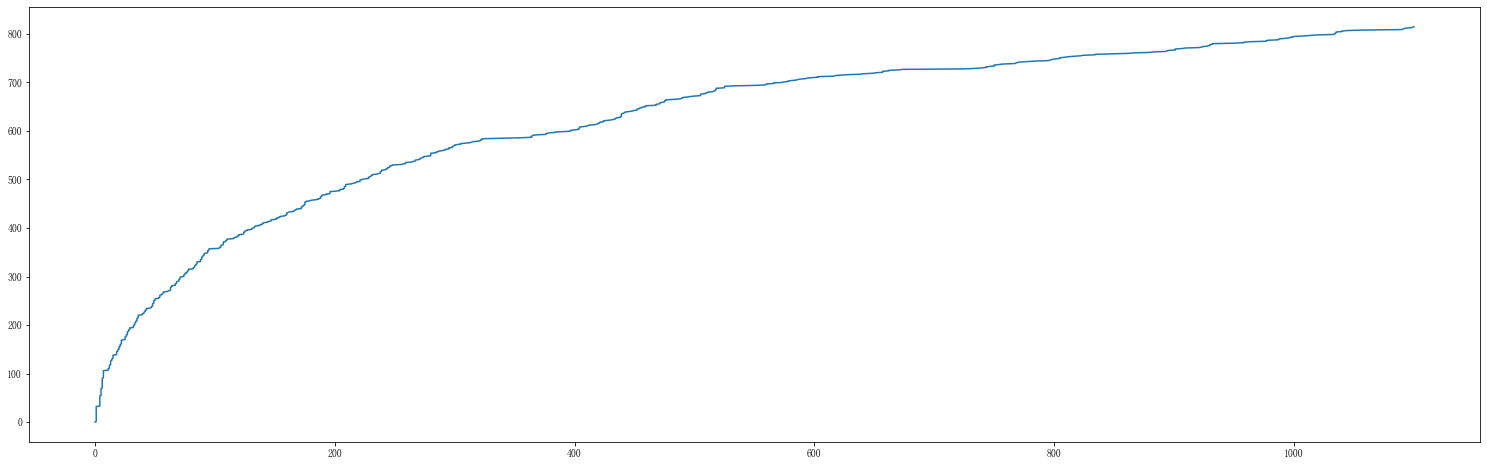

In [303]:
# 画 R 值（时间间隔）的折线图，便于后续对数据进行分组
plt.figure(figsize=(26, 8))
x = rfm_data['时间间隔'].sort_values()
y = rfm_data.index
plt.plot(x, y)

In [304]:
# 定义函数按照区间划分 R 值
def caculate_r(s):
    if s <= 30:
        return 5
    elif s <= 60:
        return 4
    elif s <= 180:
        return 3
    elif s <= 365:
        return 2
    else:
        return 1

In [305]:
# 对 R 值进行评分
rfm_data['R评分'] = rfm_data['时间间隔'].agg(caculate_r)
rfm_data

,客户,时间间隔,总次数,总销量,R评分
0,一二三三国际贸易（福建）有限公司,1,233,59236.0,5
1,七彩动漫玩具商行,15,90,4911.0,5
2,三亚富嘉文具用品有限公司,78,143,4517.0,3
3,三河市首鼎体育用品销售有限公司,49,120,7776.0,4
4,上书房（廊坊）文化传播有限公司,124,35,151.0,3
...,...,...,...,...,...
811,鹤城区小宝贝玩具批发部,581,18,830.0,1
812,黄文平,67,121,6141.0,3
813,黄若惜,193,22,880.0,2
814,黑龙江鑫颐源商贸有限公司,410,62,747.0,1


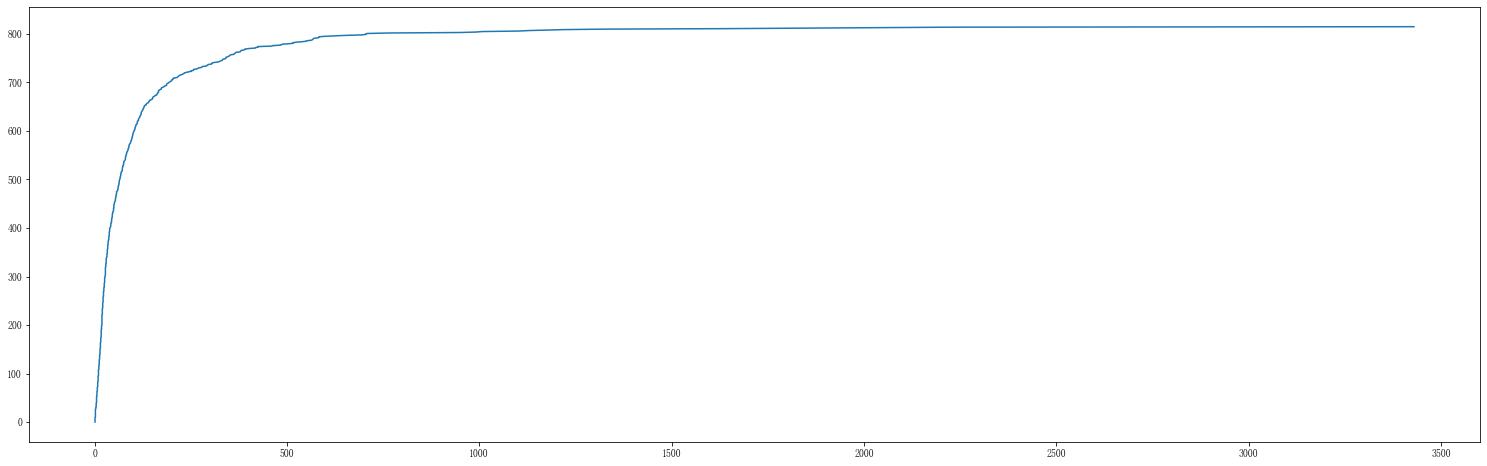

In [306]:
# 画 F 值（总次数）的折线图，便于后续对数据进行分组
plt.figure(figsize=(26, 8))
x = rfm_data['总次数'].sort_values()
y = rfm_data.index
plt.plot(x, y)

In [307]:
# 定义函数按照区间划分 F 值
def caculate_f(s):
    if s <= 90:
        return 1
    elif s <= 260:
        return 2
    elif s <= 430:
        return 3
    elif s <= 600:
        return 4
    else:
        return 5

In [308]:
# 对 F 值进行评分
rfm_data['F评分'] = rfm_data['总次数'].agg(caculate_f)
rfm_data

,客户,时间间隔,总次数,总销量,R评分,F评分
0,一二三三国际贸易（福建）有限公司,1,233,59236.0,5,2
1,七彩动漫玩具商行,15,90,4911.0,5,1
2,三亚富嘉文具用品有限公司,78,143,4517.0,3,2
3,三河市首鼎体育用品销售有限公司,49,120,7776.0,4,2
4,上书房（廊坊）文化传播有限公司,124,35,151.0,3,1
...,...,...,...,...,...,...
811,鹤城区小宝贝玩具批发部,581,18,830.0,1,1
812,黄文平,67,121,6141.0,3,2
813,黄若惜,193,22,880.0,2,1
814,黑龙江鑫颐源商贸有限公司,410,62,747.0,1,1


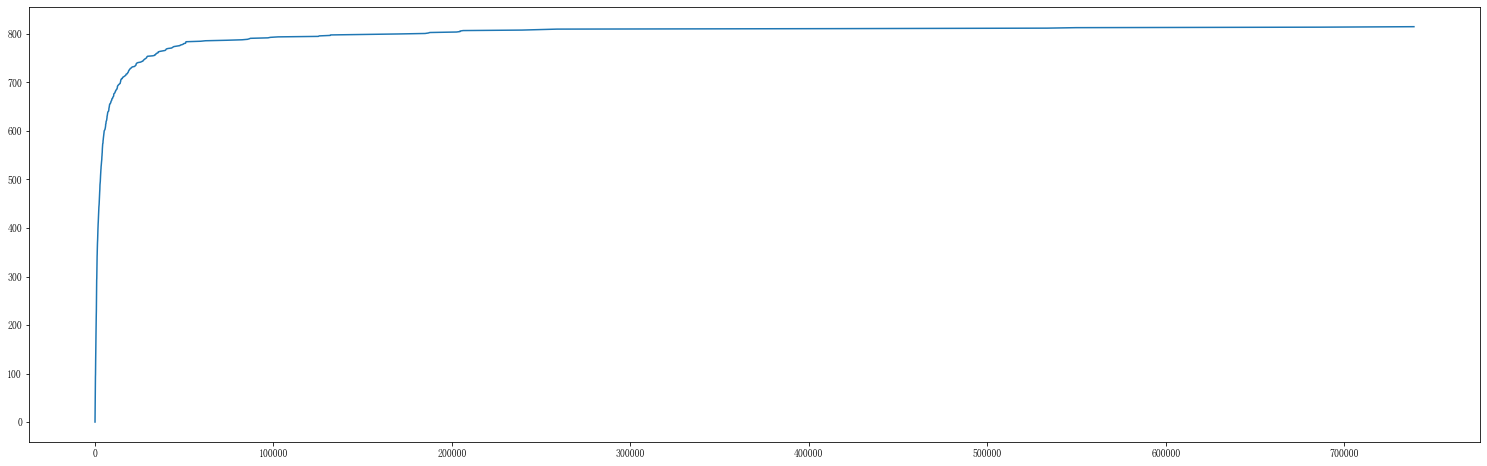

In [309]:
# 画 M 值（总金额）的折线图，便于后续对数据进行分组
plt.figure(figsize=(26, 8))
x = rfm_data[column_name1].sort_values()
y = rfm_data.index
plt.plot(x, y)

In [310]:
# 定义函数按照区间划分 M 值
def caculate_m(s):
    if s <= 2000:
        return 1
    elif s <= 5000:
        return 2
    elif s <= 8000:
        return 3
    elif s <= 15000:
        return 4
    else:
        return 5

In [311]:
# 对 M 值进行评分
rfm_data['M评分'] = rfm_data[column_name1].agg(caculate_m)
# 计算 R评分、F评分、M评分的平均数
r_avg = rfm_data['R评分'].mean()
f_avg = rfm_data['F评分'].mean()
m_avg = rfm_data['M评分'].mean()

print('R评分的均值为：{}，F评分的均值为{},M评分的均值为{}'.format(r_avg, f_avg, m_avg))

R评分的均值为：2.8566176470588234，F评分的均值为1.4803921568627452,M评分的均值为2.079656862745098


In [312]:
# 将R评分、F评分、M评分 的数据分别与对应的平均数做比较
rfm_data['R向量化'] = (rfm_data['R评分'] > r_avg) * 1
rfm_data['F向量化'] = (rfm_data['F评分'] > f_avg) * 1
rfm_data['M向量化'] = (rfm_data['M评分'] > m_avg) * 1
# 拼接R评分、F评分、M评分
rfm_score = rfm_data['R向量化'].astype(str) + rfm_data['F向量化'].astype(str) + rfm_data['M向量化'].astype(str)

In [313]:
# 定义字典标记 RFM 评分档对应的用户分类名称
transform_label = {
    '111':'重要价值用户',
    '101':'重要发展用户',
    '011':'重要保持用户',
    '001':'重要挽留用户',
    '110':'一般价值用户',
    '100':'一般发展用户',
    '010':'一般保持用户',
    '000':'一般挽留用户'
}

level_label = {
    '重要价值用户':'A',
    '重要发展用户':'A',
    '重要保持用户':'B',
    '重要挽留用户':'B',
    '一般价值用户':'B',
    '一般发展用户':'B',
    '一般保持用户':'C',
    '一般挽留用户':'C'
}

In [314]:
# 将RFM评分替换成具体的客户类型
rfm_data['客户类型'] = rfm_score.replace(transform_label)
rfm_data['客户分级'] = rfm_data['客户类型'].replace(level_label)
# 按【客户类型】分组，统计用户的数量
customer_data = rfm_data.groupby('客户类型')['客户'].count()
customer_data

客户类型
一般价值用户     53
一般保持用户     12
一般发展用户    218
一般挽留用户    312
重要价值用户    163
重要保持用户     15
重要发展用户     24
重要挽留用户     19
Name: 客户, dtype: int64

Text(0.5, 1.0, '不同客户的数量分布')

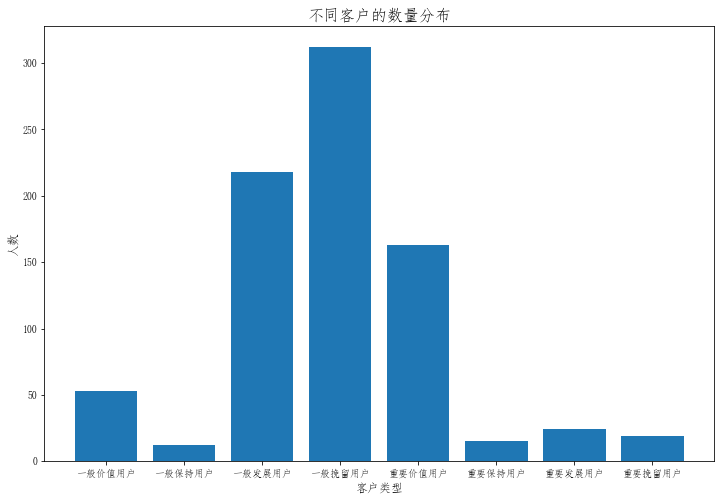

In [315]:
# 绘制柱状图
plt.figure(figsize=(12, 8))
plt.bar(customer_data.index, customer_data)
plt.xlabel('客户类型', fontsize=12)
plt.ylabel('人数', fontsize=12)
plt.title('不同客户的数量分布', fontsize=16)

Text(0.5, 1.0, '不同客户占比情况')

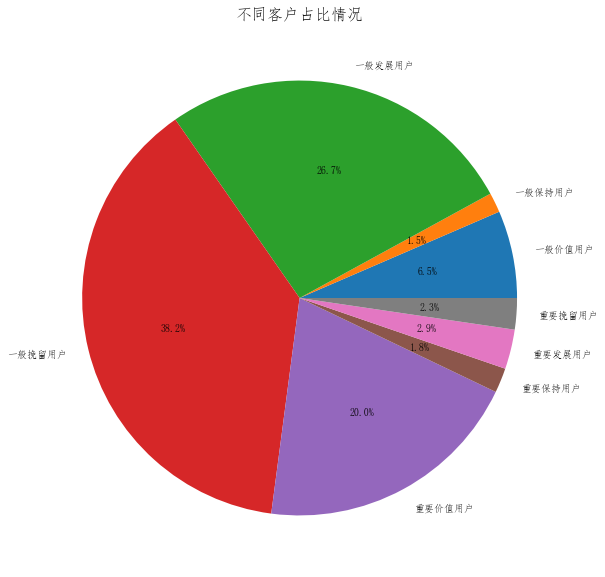

In [316]:
# 绘制饼图
plt.figure(figsize=(14, 10))
plt.pie(customer_data, labels=customer_data.index, autopct='%0.1f%%')
plt.title('不同客户占比情况', fontsize=16)

In [317]:
# *****************************************写入数据库*******************************************#
rfm_data.to_sql('bi_rfm', engine1, schema='bi', if_exists='replace', index=False)
engine.dispose()
engine1.dispose()

rfm_data.to_sql(name='bi_rfm', con=conn, if_exists='replace', index=False)
conn.dispose() 